# Profile

In [2]:
import os
import multiprocessing
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

datadir = '/root/input/rsna-2022-cervical-spine-fracture-detection'
libdir = '/root/workspace/RSNA2022RAWE'
outputdir = '/root/workspace/RSNA2022RAWE'
otherdir = '/root/workspace/RSNA2022RAWE'
train_bs_ = 4
valid_bs_ = 8
num_workers_ = multiprocessing.cpu_count()

# CFG

In [3]:
class CFG:
    seed=42
    device='GPU'
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5

    target_cols=["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    num_classes=7

    accum_iter=1
    max_grad_norm=1000
    print_freq=100
    normalize_mean=[0.4824, 0.4824, 0.4824] # [0.485, 0.456, 0.406] [0.4824, 0.4824, 0.4824]
    normalize_std=[0.22, 0.22, 0.22] # [0.229, 0.224, 0.225] [0.22, 0.22, 0.22]
    
    suffix="401" 
    fold_list=[0] 
    epochs=25
    model_arch="resnet50d" # tf_efficientnetv2_s, resnest50d
    img_size=320
    optimizer="AdamW"
    scheduler="CosineAnnealingLR"
    loss_fn="BCEWithLogitsLoss"
    scheduler_warmup="GradualWarmupSchedulerV3" 

    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1 # CosineAnnealingLR
    
    seq_len = 24
    # lr=5e-4
    lr = 0.001
    min_lr=1e-6 
    weight_decay=0
    dropout=0.1

    gpu_parallel=False
    n_early_stopping=4
    debug=False
    multihead=False

# Import

In [4]:
!pip install -U scikit-image
!pip install timm
!pip install nibabel
! pip install python-gdcm
! pip install pylibjpeg pylibjpeg-libjpeg pydicom
!pip install -U albumentations
!pip install segmentation_models_pytorch
!pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached scikit_image-0.19.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (13.5 MB)
  Using cached tifffile-2021.11.2-py3-none-any.whl (178 kB)
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.6 MB/s eta 0:00:0000:01
  Using cached torch-1.13.0-cp37-cp37m-manylinux1_x86_64.whl (890.2 MB)
  Using cached huggingface_hub-0.11.0-py3-none-any.whl (182 kB)
  Using cached torchvision-0.14.0-cp37-cp37m-manylinux1_x86_64.whl (24.3 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x

In [5]:
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom
import gc 
from torch.nn import DataParallel



if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

# helper

In [6]:
train_df = pd.read_pickle(f'{datadir}/vertebrae_df.pkl')
submission_df = pd.read_csv(f'{datadir}/sample_submission.csv')

train_df = train_df[train_df["StudyInstanceUID"] != "1.2.826.0.1.3680043.20574"].reset_index(drop=True)
train_df = train_df[train_df["StudyInstanceUID"] != "1.2.826.0.1.3680043.29952"].reset_index(drop=True)
train_df

gkf = GroupKFold(n_splits=CFG.fold_num)
folds = gkf.split(X=train_df, y=None, groups=train_df['StudyInstanceUID'])

In [7]:
if CFG.device == 'TPU':
    import os
    VERSION = "1.7"
    CP_V = "36" if ENV == "colab" else "37"
    wheel = f"torch_xla-{VERSION}-cp{CP_V}-cp{CP_V}m-linux_x86_64.whl"
    url = f"https://storage.googleapis.com/tpu-pytorch/wheels/{wheel}"
    !pip3 -q install cloud-tpu-client==0.10 $url
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.train_bs = CFG.train_bs // CFG.nprocs
    device = xm.xla_device()
    
elif CFG.device == "GPU":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
print(device)

cuda


In [9]:
print(torch.version.cuda)

11.7


In [10]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=outputdir+'stage2_train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger(outputdir+f'/stage2_train{CFG.suffix}.log')

if CFG.device=='TPU' and CFG.nprocs==8:
    loginfo = xm.master_print
    cusprint = xm.master_print
else:
    loginfo = LOGGER.info
    cusprint = print



def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

# DataSet

In [11]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_id = row["StudyInstanceUID"]
        slice_num_list = row['slice_num_list']
        slice_list = []
        for s_num in slice_num_list:
            path = f"{datadir}/train_images/{study_id}/{s_num}.dcm"
            img = load_dicom(path)
            if len(slice_list) == 0:
                imgh = img.shape[0]
                imgw = img.shape[1]
            elif img.shape != (imgh, imgw):
                img = cv2.resize(img,(imgh,imgw))

            slice_list.append(img)
        for _ in range(CFG.seq_len - len(slice_list)):
            slice_list.append(np.zeros((imgh,imgw)))

        image = np.stack(slice_list, axis=2) # 512*512*seq_len; 0-1

        assert image.shape == (imgh, imgw, CFG.seq_len)

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        image = np.transpose(image, (2, 0, 1)) # seq_len*img_size*img_size; 0-1
        return torch.from_numpy(image), torch.tensor(row['label']).float()

# Augmentation

In [12]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations
from albumentations.pytorch import ToTensorV2

def get_transforms(*, data):
    if data == 'train':
        return Compose([
            RandomResizedCrop(CFG.img_size, CFG.img_size, scale=(0.9, 1), p=1), 
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.7),
            RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
            CLAHE(clip_limit=(1,4), p=0.5),
            OneOf([
                OpticalDistortion(distort_limit=1.0),
                GridDistortion(num_steps=5, distort_limit=1.),
                ElasticTransform(alpha=3),
            ], p=0.2),
            OneOf([
                GaussNoise(var_limit=[10, 50]),
                GaussianBlur(),
                MotionBlur(),
                MedianBlur(),
            ], p=0.2),
            Resize(CFG.img_size, CFG.img_size),
            OneOf([
                JpegCompression(),
                Downscale(scale_min=0.1, scale_max=0.15),
            ], p=0.2),
            IAAPiecewiseAffine(p=0.2),
            IAASharpen(p=0.2),
            Cutout(max_h_size=int(CFG.img_size * 0.1), max_w_size=int(CFG.img_size * 0.1), num_holes=5, p=0.5),
            ])
    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),
            OneOf([
                # GaussNoise(),
                GaussianBlur(),
                MotionBlur(),
                # MedianBlur(),
            ], p=0.3),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.3),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)    
    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
        ])

# Train Images

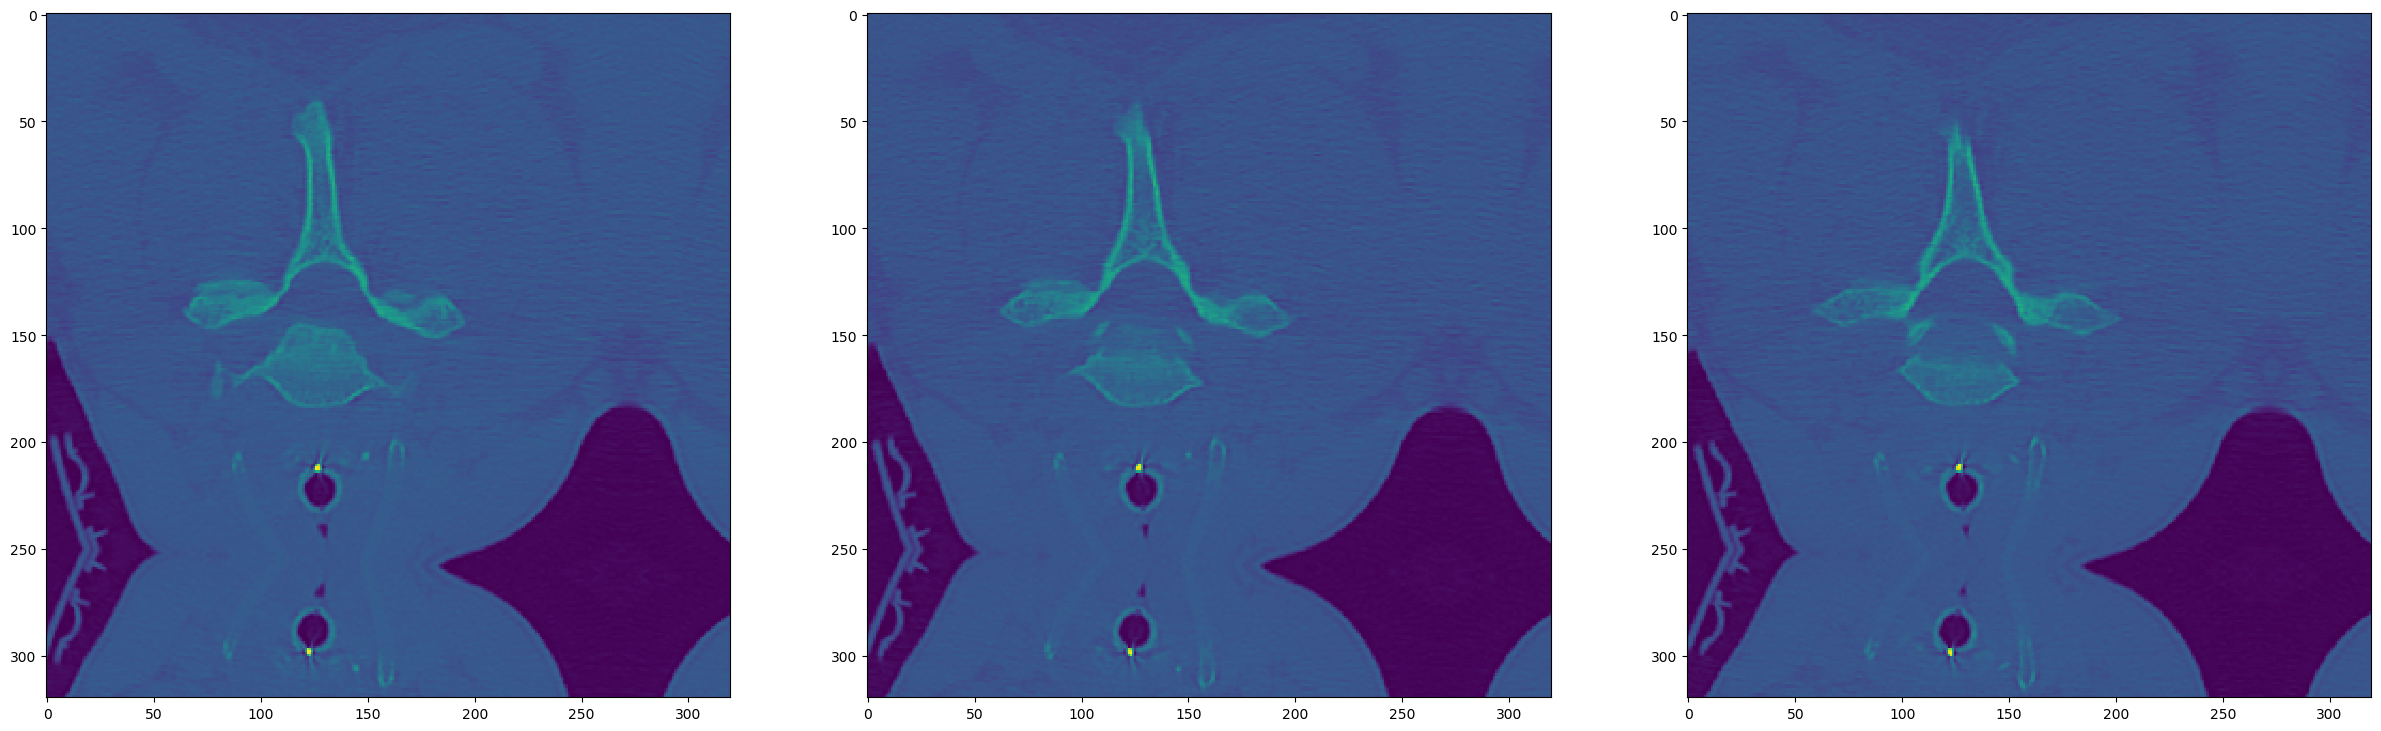

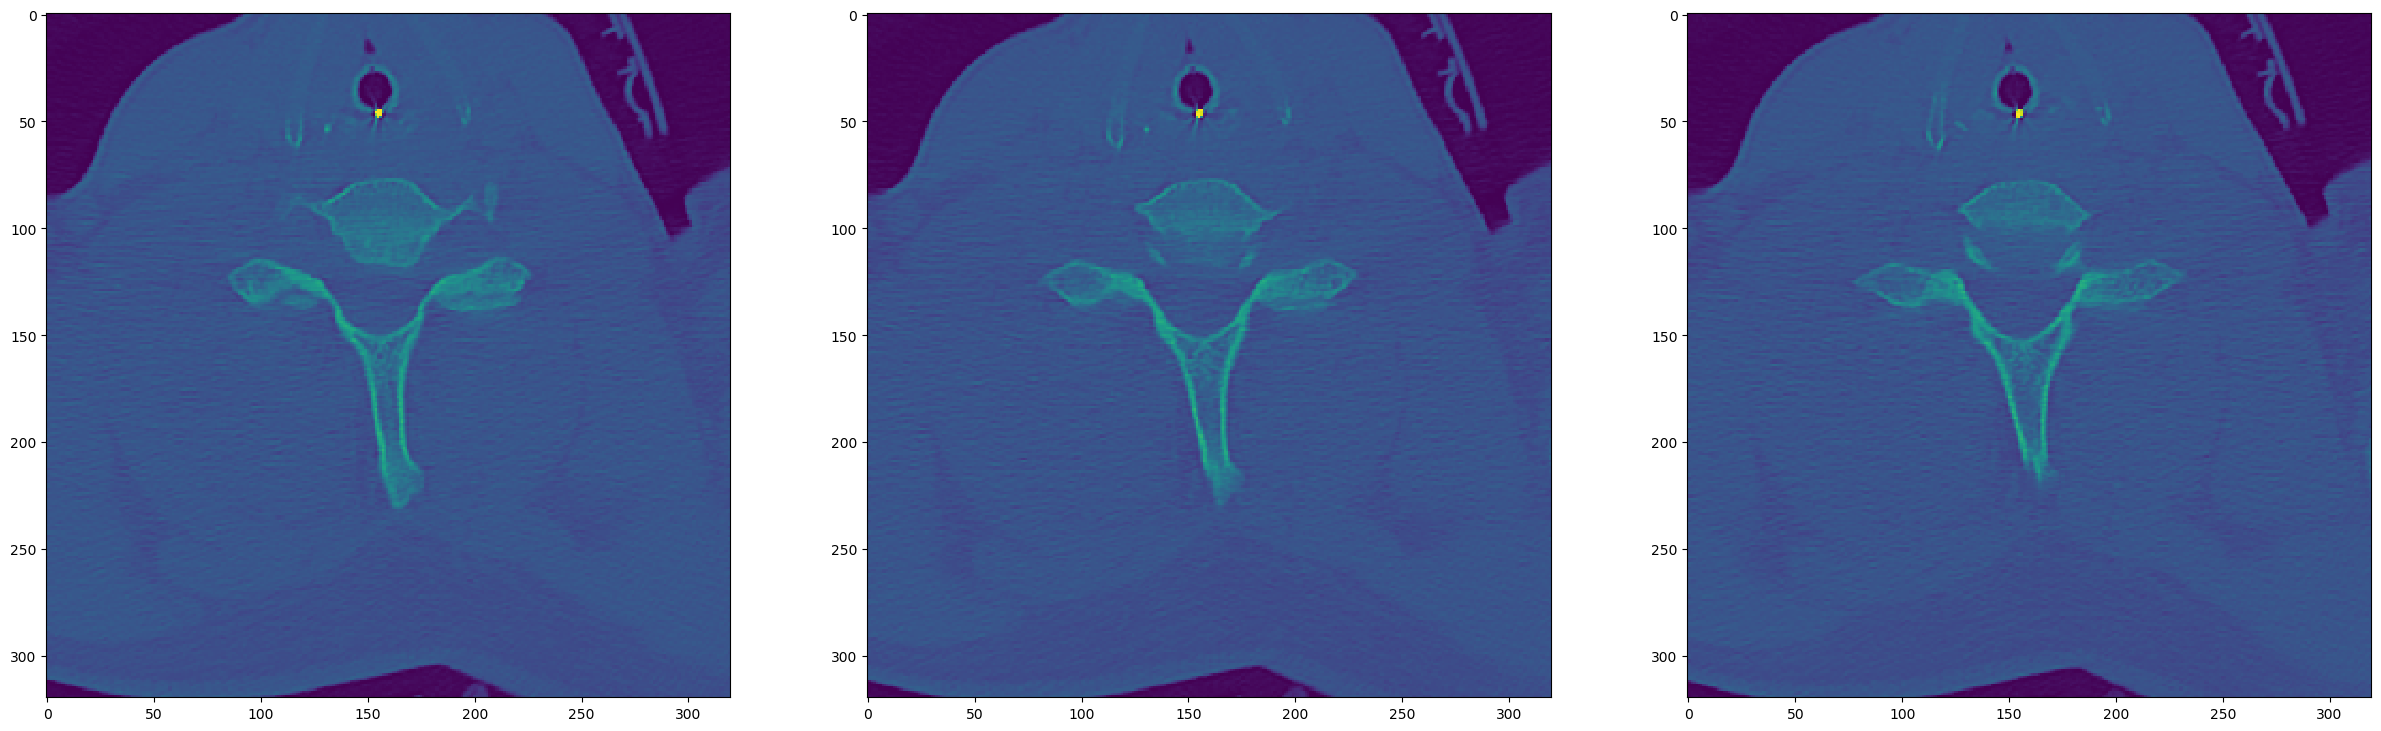

In [51]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df,
    transform=get_transforms(data='light_train') # None, get_transforms(data='check')
    )
rcParams['figure.figsize'] = 30,20

for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = 712
    img, label= dataset_show[idx]
    # axarr[0].imshow(img) # transform=None
    axarr[0].imshow(img[0])
    axarr[1].imshow(img[1])
    axarr[2].imshow(img[2])
plt.show()

# Valid Images

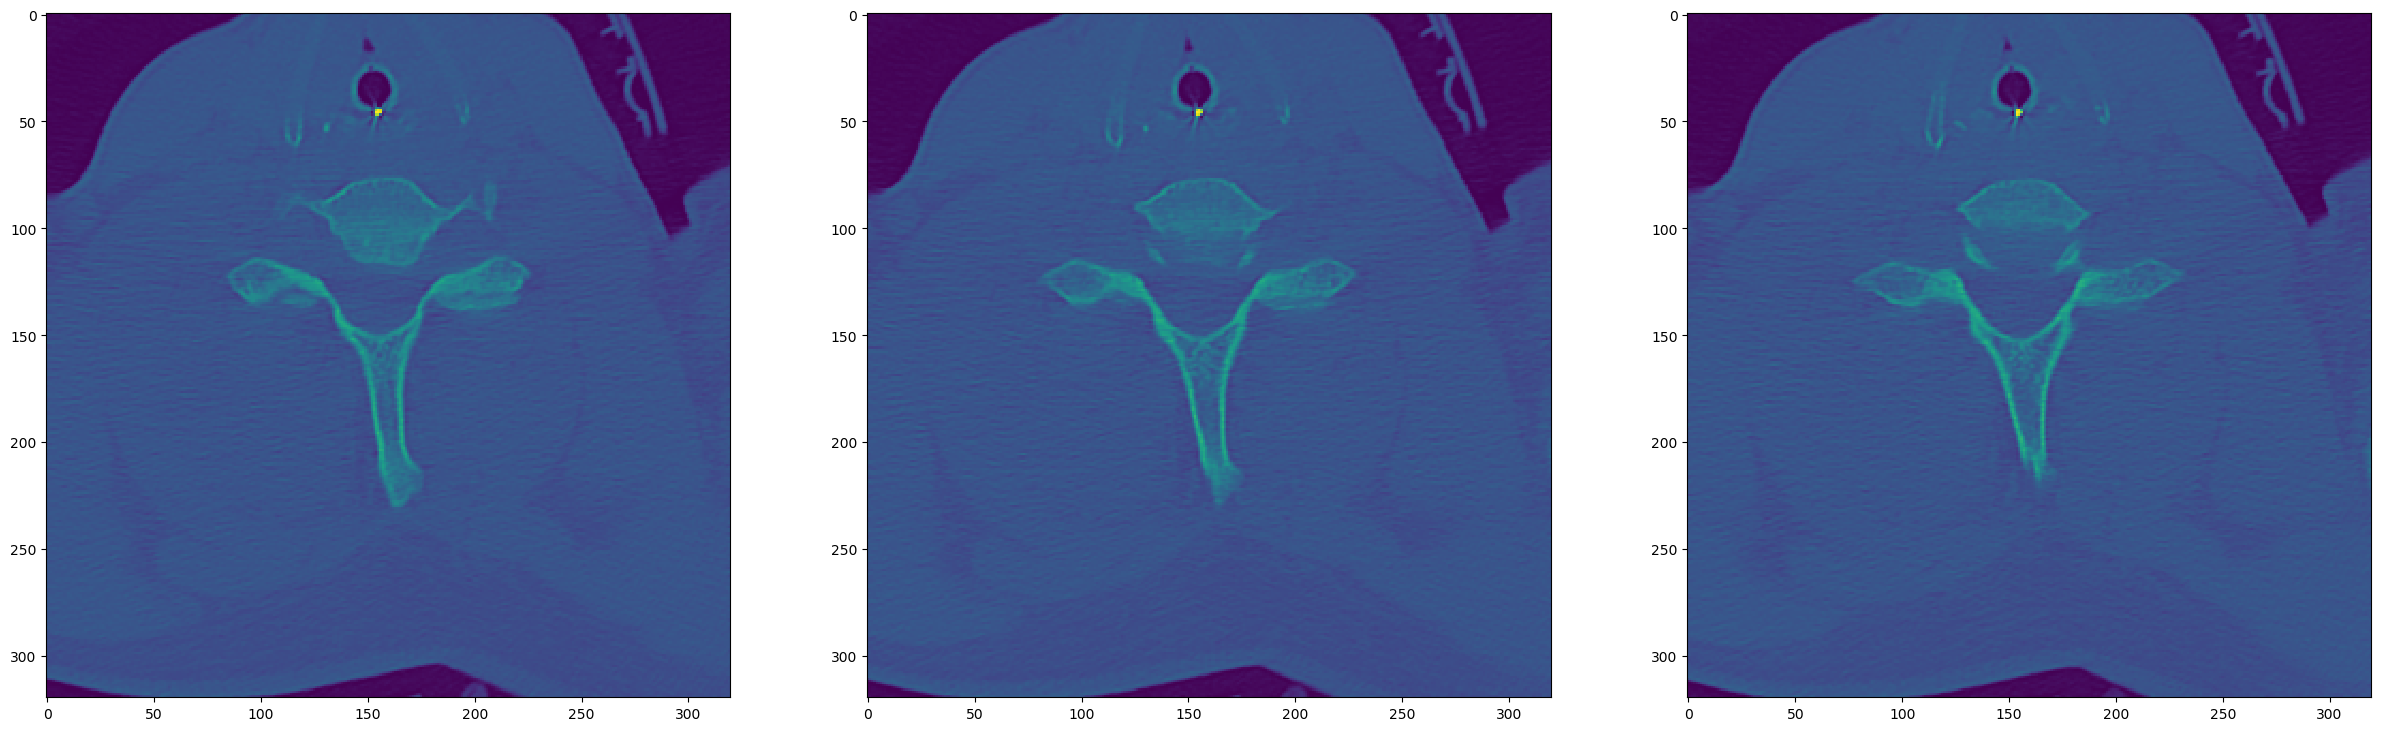

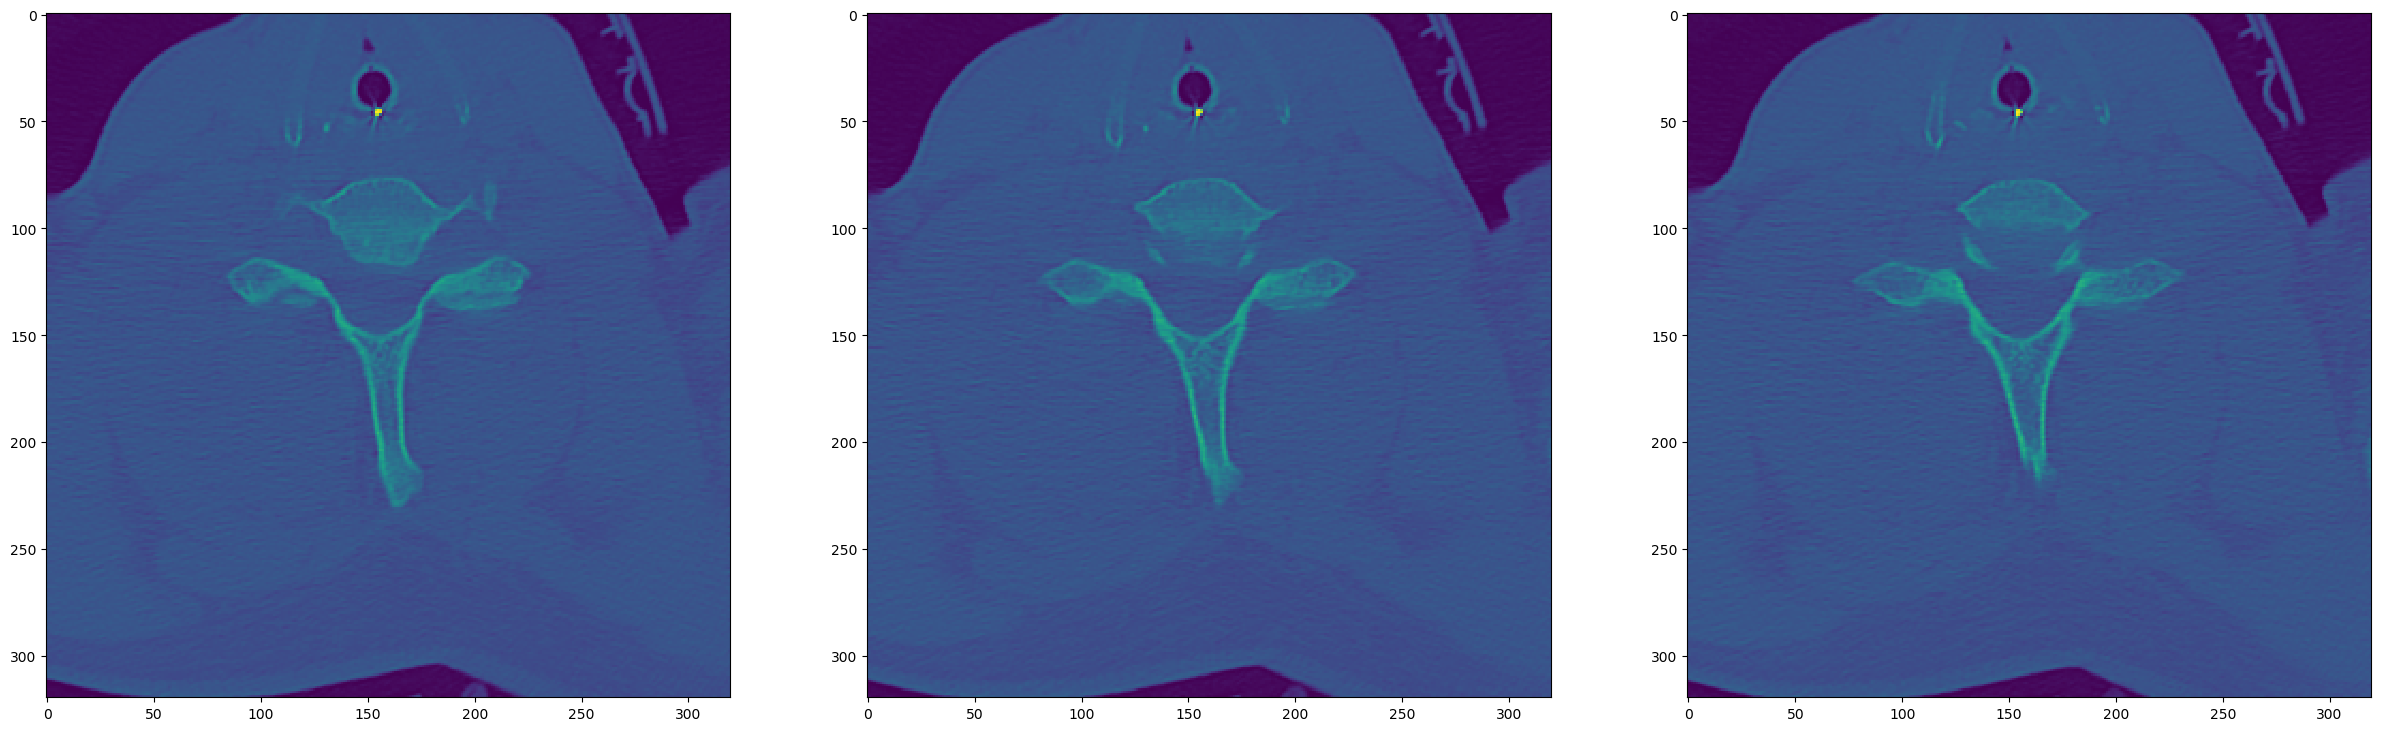

In [52]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df,
    transform=get_transforms(data='valid') # None, get_transforms(data='check')
    )
rcParams['figure.figsize'] = 30,20

for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = 712
    img, label= dataset_show[idx]
    # axarr[0].imshow(img) # transform=None
    axarr[0].imshow(img[0])
    axarr[1].imshow(img[1])
    axarr[2].imshow(img[2])
plt.show()

# Image Preprocess: Flip & Rotation

In [45]:
def get_transforms(*, data):
    if data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5)
            ], p=1.0)    
    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
        ])

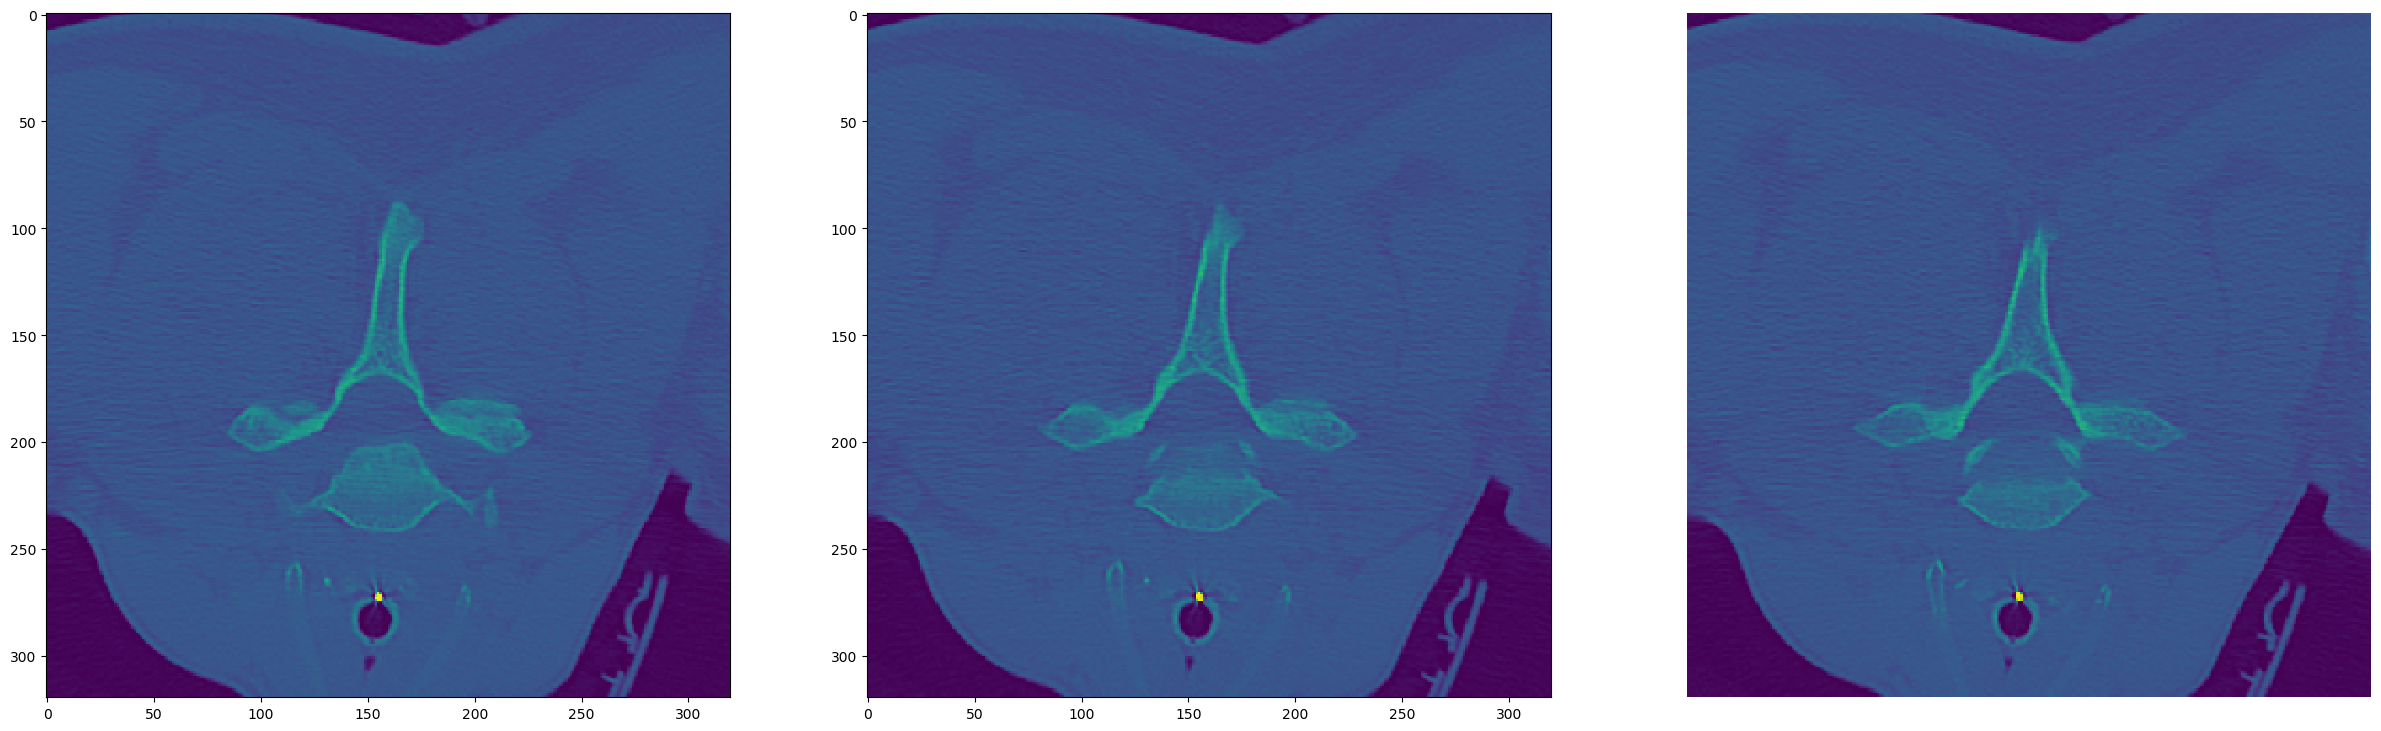

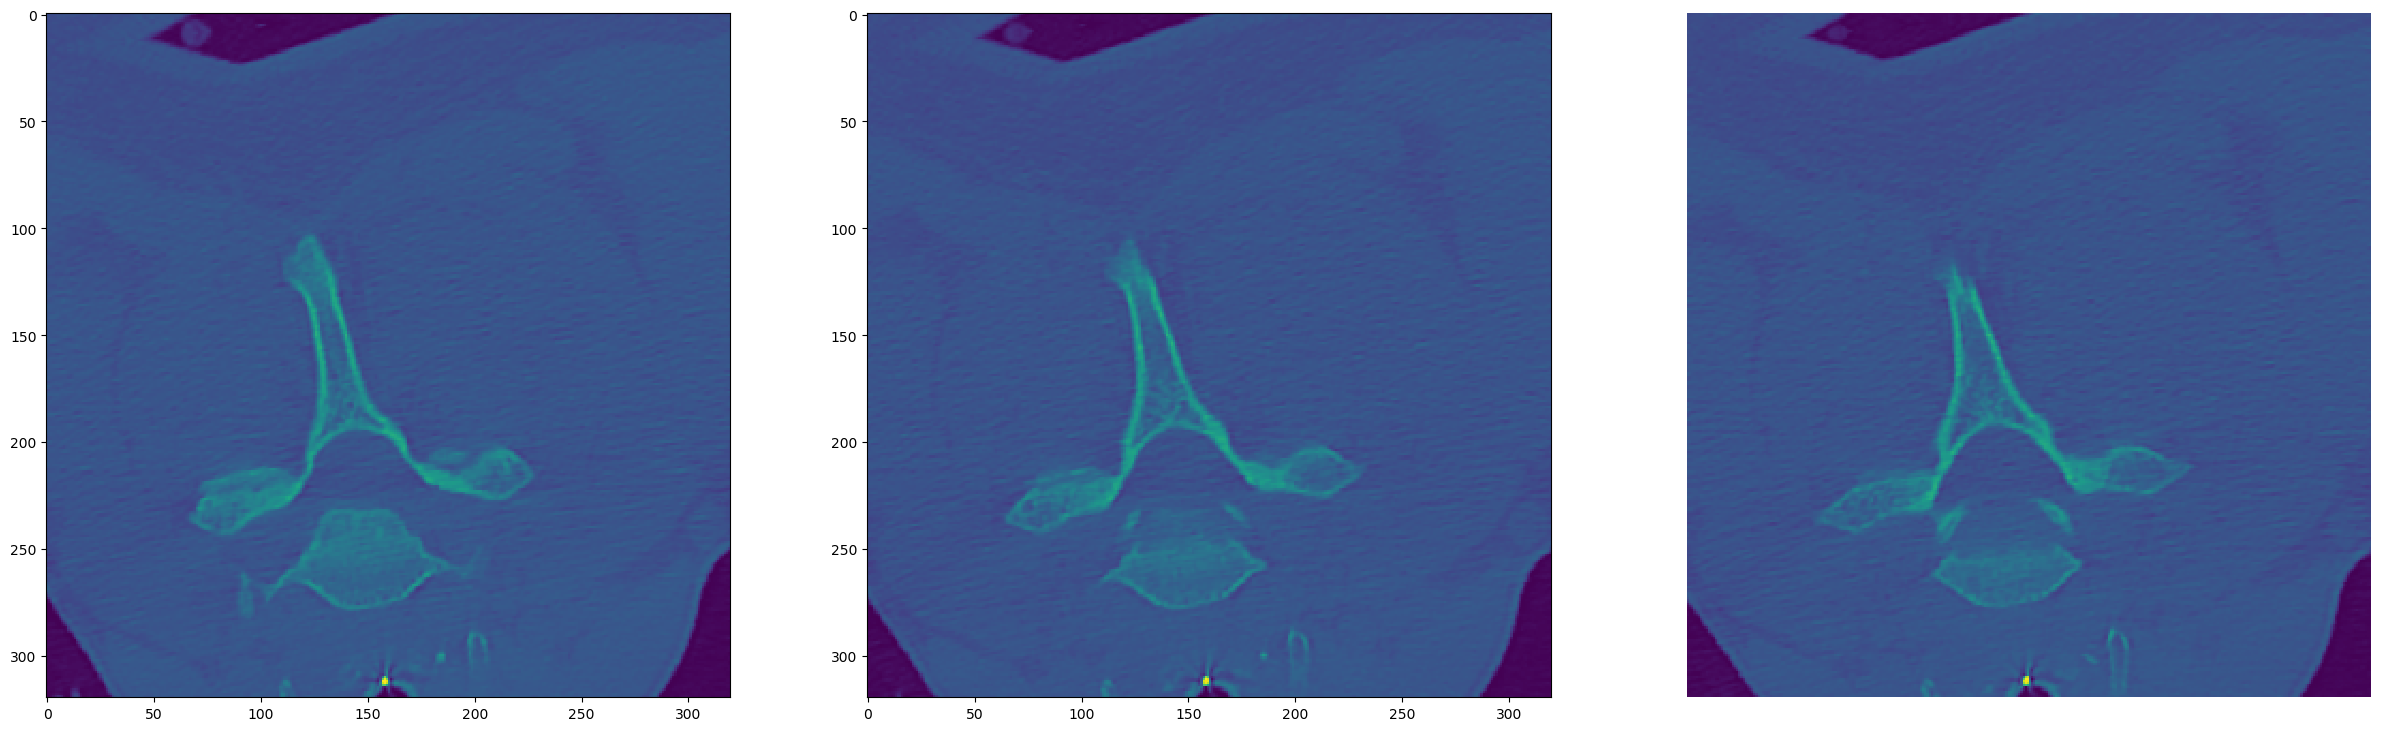

In [53]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df,
    transform=get_transforms(data='light_train') # None, get_transforms(data='check')
    )
rcParams['figure.figsize'] = 30,20

for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = 712
    img, label= dataset_show[idx]
    # axarr[0].imshow(img) # transform=None
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');
plt.show()

# Image Preprocess: Blur & Distortion

In [56]:
def get_transforms(*, data):
    if data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            OneOf([
                GaussNoise(),
                GaussianBlur(),
                MotionBlur(),
                MedianBlur(),
            ], p=0.3),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.3)
            ], p=1.0)    
    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
        ])

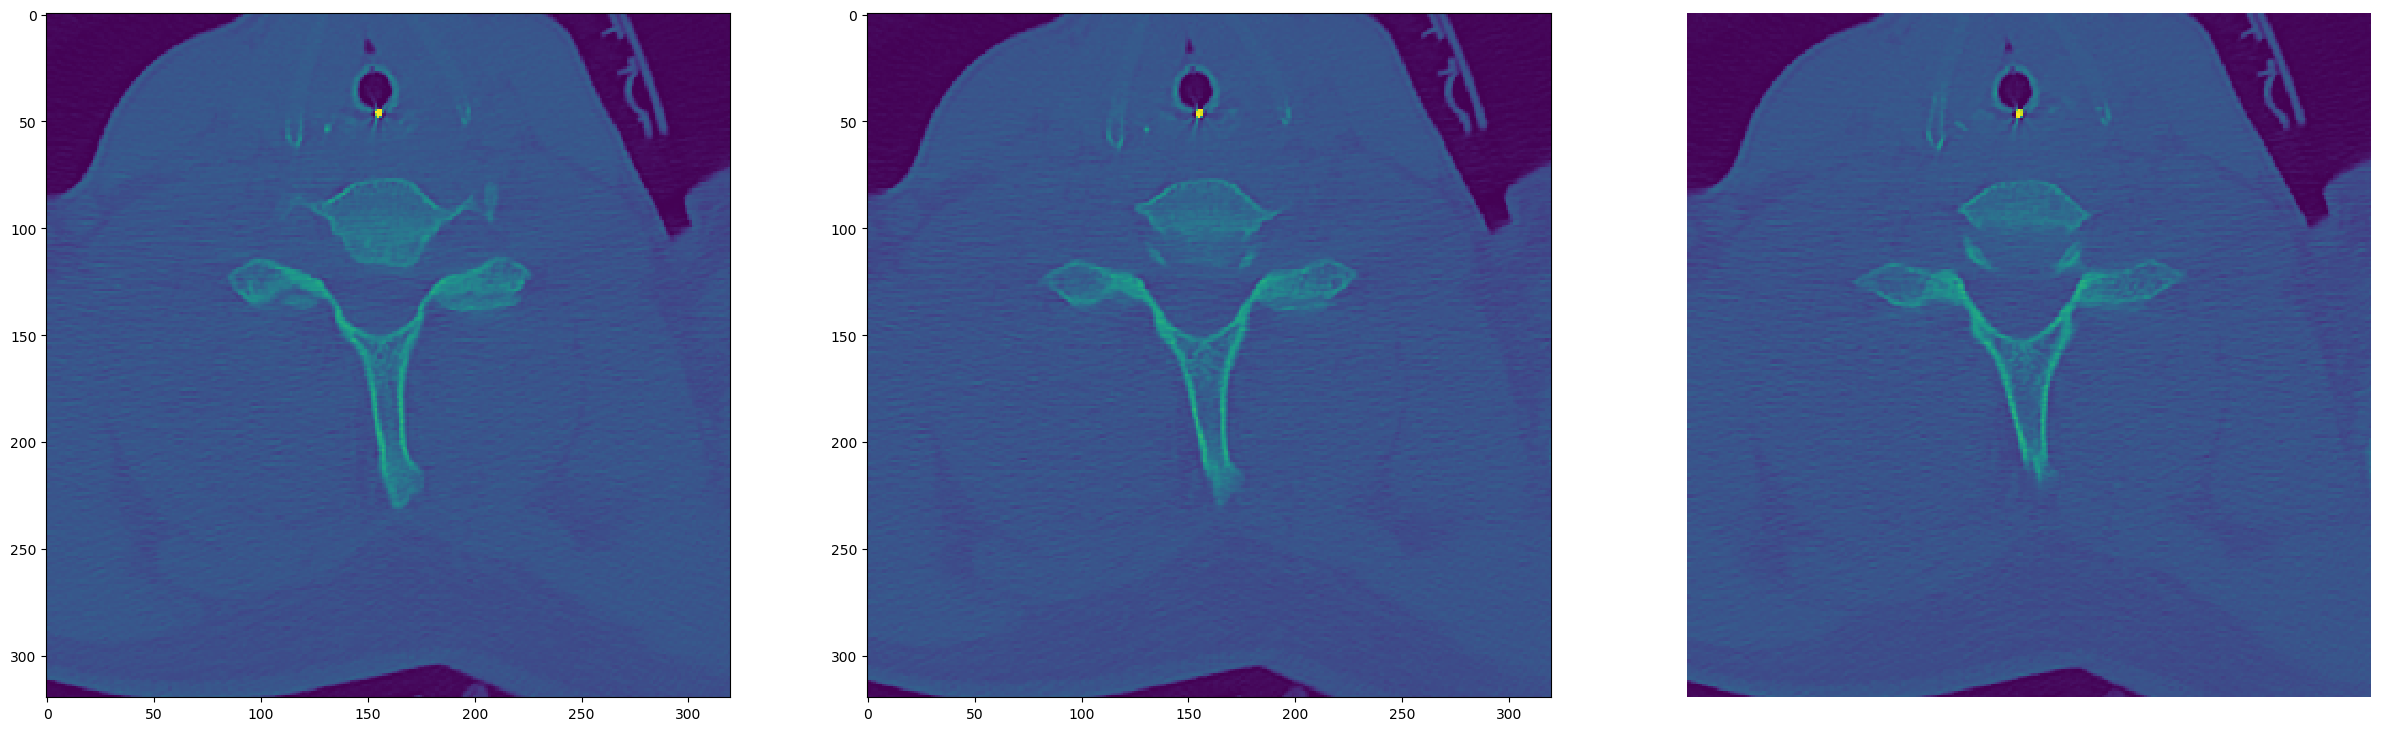

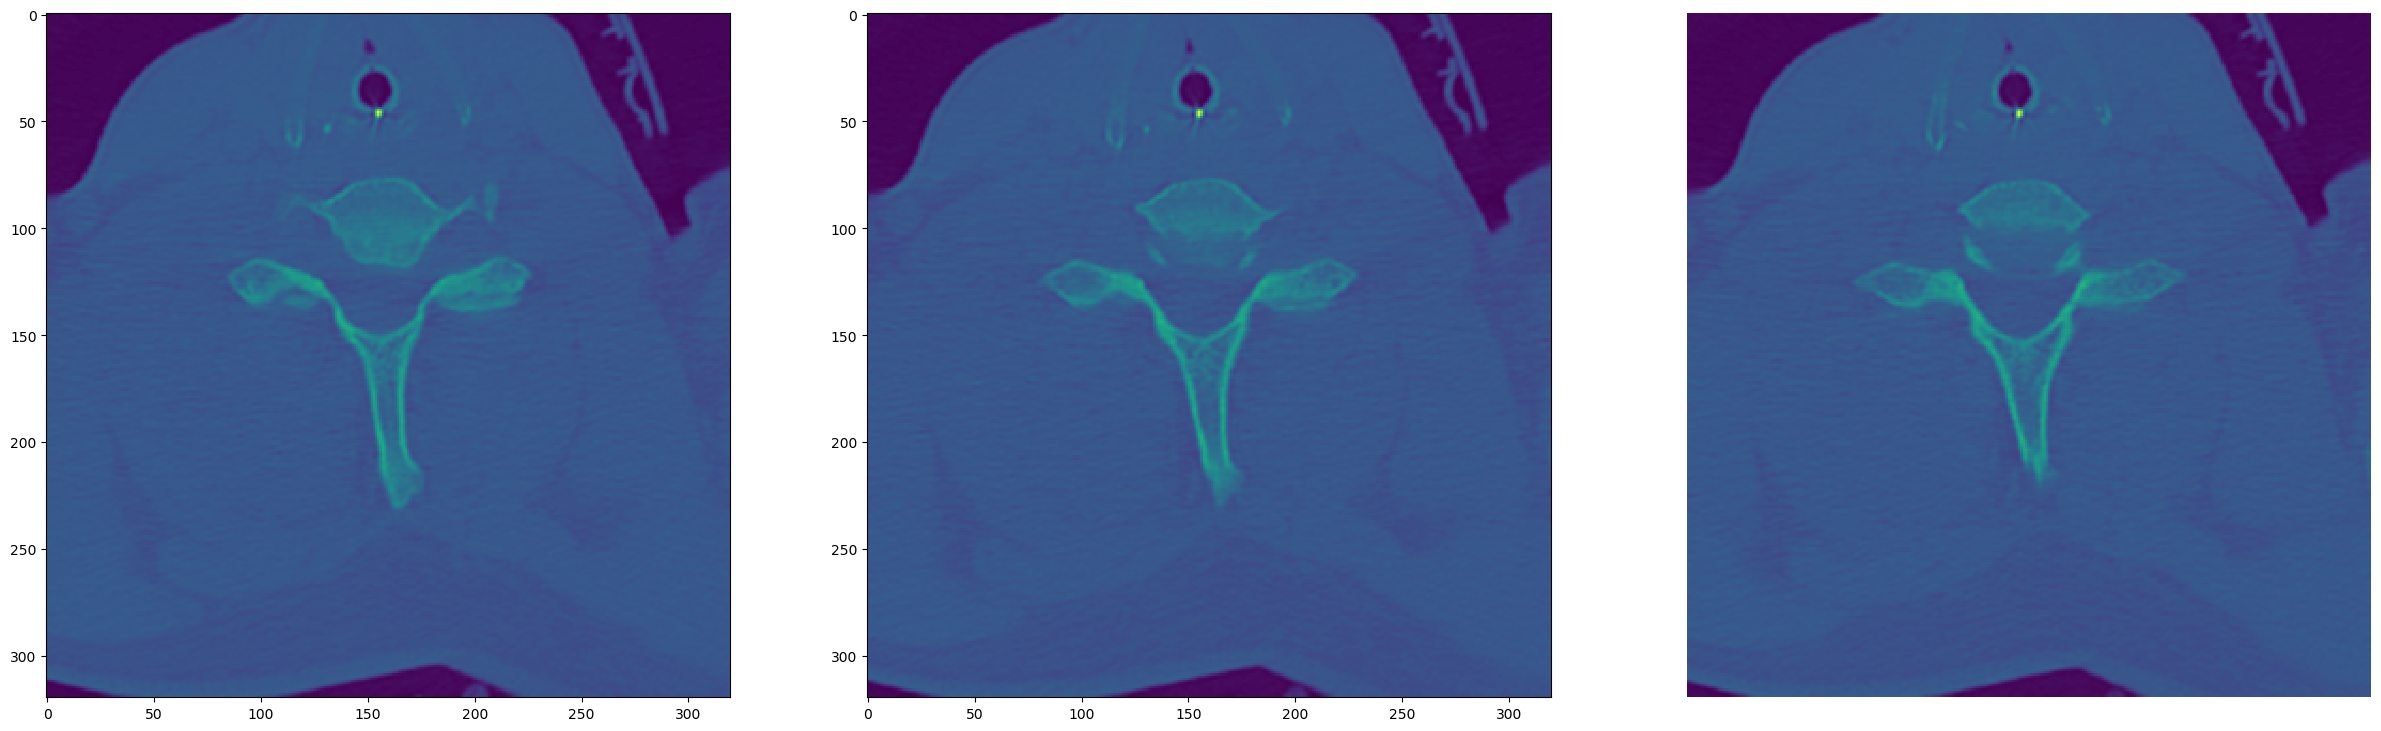

In [57]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df,
    transform=get_transforms(data='light_train') # None, get_transforms(data='check')
    )
rcParams['figure.figsize'] = 30,20

for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = 712
    img, label= dataset_show[idx]
    # axarr[0].imshow(img) # transform=None
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');
plt.show()